#### Install Requirements

In [ ]:
!pip install datasets wandb evaluate accelerate -qU
!pip install -q -U bitsandbytes
!pip install peft

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /to_directory

#### Logging into Weights and Biases

In [ ]:
# Setup enviroment variables to enable logging to Weights & Biases
import os
# can be "end", "checkpoint" or "false"
os.environ['WANDB_LOG_MODEL'] = "checkpoint"
# the name of the wandb project defaults to `huggingface`
os.environ['WANDB_PROJECT'] = "hf_transformers"

In [ ]:
# Login and authenticate Weights & Biases
import wandb
wandb.login()

In [ ]:
# https://huggingface.co/docs/transformers/model_doc/t5#t5tokenizer
access_token = 'token_string'
wandb_project = "t5-finetune-paraphrases-trainer"
dataset_name = "humarin/chatgpt-paraphrases"
model_id = "google-t5/t5-base"
base_model_name = "google"
run_name = base_model_name + "-" + wandb_project
save_directory = "./outputs/" + run_name
gradient_accumulation_steps = 1
max_input_length = 64
max_output_length = 64#100

In [ ]:
import torch
import numpy as np

# WandB – Initialize a new run
wandb.init(project=wandb_project)

# WandB – Config is a variable that holds and saves hyperparameters and inputs
# Defining some key variables that will be used later on in the training
config = wandb.config          # Initialize config
config.TRAIN_BATCH_SIZE = 64#100    # input batch size for training (default: 64)
config.VALID_BATCH_SIZE = 64#100    # input batch size for testing (default: 1000)
config.TRAIN_EPOCHS = 15#50        # number of epochs to train (default: 10)
config.VAL_EPOCHS = 1
config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
config.SEED = 42               # random seed (default: 42)

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(config.SEED) # pytorch random seed
np.random.seed(config.SEED) # numpy random seed
torch.backends.cudnn.deterministic = True

In [ ]:
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

#### Accelerate

In [ ]:
from accelerate import Accelerator, DataLoaderConfiguration

dataloader_config = DataLoaderConfiguration(
    dispatch_batches=None,
    split_batches=False,
    even_batches=True,
    use_seedable_sampler=True
)

accelerator = Accelerator(dataloader_config=dataloader_config)

#### Load Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset(dataset_name, token=access_token)

In [ ]:
import ast
# Convert string representation of list to actual list
def convert_paraphrases_to_list(example):
    example['paraphrases'] = ast.literal_eval(example['paraphrases'])
    return example

dataset = dataset["train"].map(convert_paraphrases_to_list)

In [ ]:
# Expand each row for each paraphrase
def expand_dataset(examples):
    new_examples = {'text': [], 'paraphrase': [], 'category': [], 'source': []}
    for text, paraphrases, category, source in zip(examples['text'], examples['paraphrases'], examples['category'], examples['source']):
        for paraphrase in paraphrases:
            new_examples['text'].append(text)
            new_examples['paraphrase'].append(paraphrase)
            new_examples['category'].append(category)
            new_examples['source'].append(source)
    return new_examples

# Expand the dataset
dataset = dataset.map(expand_dataset, batched=True, remove_columns=['paraphrases'])

#### Adjust input/output sequence lengths

In [ ]:
# Find the maximum input and output sequence length
import matplotlib.pyplot as plt
import statistics

def plot_sequence_lengths(dataset_obj, seq_length=150, input_text=True, to_plot=True):

  # Initialize a list to store sequence lengths
  sequence_lengths = []

  # list of indices that are too long
  too_long = []

  # Loop over the dataset and get the length of text sequences
  for idx, example in enumerate(dataset_obj):
    if input_text:
      sequence_lengths.append(len(example['text']))
    else:
      sequence_lengths.append(len(example['paraphrase']))
    if sequence_lengths[idx] >= seq_length:
      too_long.append(idx)

  # Plot histogram
  if to_plot:
    plt.figure(figsize=(4,2))
    plt.grid()
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Text Sequence')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

  print(f"Average sequence length: {sum(sequence_lengths)/len(sequence_lengths)}")
  print(f"Min, Median, Max sequence length: [{min(sequence_lengths)}, {statistics.median(sequence_lengths)}, {max(sequence_lengths)}]")

  return too_long

In [ ]:
indices_to_drop_input = plot_sequence_lengths(dataset, seq_length=200, input_text=True, to_plot=False)
print(f"Number of indices to drop for input length: {len(indices_to_drop_input)}")

Average sequence length: 91.34038650085759
Min, Median, Max sequence length: [1, 72, 1151]
Number of indices to drop for input length: 132635


In [ ]:
indices_to_drop_output = plot_sequence_lengths(dataset, seq_length=200, input_text=False, to_plot=False)
print(f"Number of indices to drop for output length: {len(indices_to_drop_output)}")

Average sequence length: 99.35036414859839
Min, Median, Max sequence length: [4, 84, 1151]
Number of indices to drop for output length: 118172


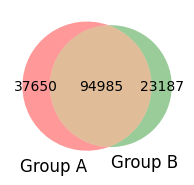

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

Ab = set(indices_to_drop_input)  - set(indices_to_drop_output)
aB = set(indices_to_drop_output) - set(indices_to_drop_input)
AB = set(indices_to_drop_input) & set(indices_to_drop_output)

plt.figure(figsize=(4,2))
venn2(subsets = (len(list(Ab)), len(list(aB)), len(list(AB))), set_labels = ('Group A', 'Group B'))
plt.show()

In [ ]:
# Drop indices in Ab, aB, and AB
import itertools

drop_indices = set(itertools.chain(list(Ab), list(aB), list(AB)))

print(f"Initial Dataset is of shape: {dataset.shape}")

# Convert generator to list to make it hashable
selected_indices = [idx for idx in range(len(dataset)) if idx not in drop_indices]

# Create a new dataset excluding those indices
dataset = dataset.select(selected_indices)

print(f"Final   Dataset is of shape: {dataset.shape}")

Initial Dataset is of shape: (2095985, 4)
Final   Dataset is of shape: (1940163, 4)


In [ ]:
'''# create new dataset exluding those idx
dataset = dataset.select(
    (
        idx for idx in range(len(dataset))
        if idx not in drop_indices
    )
)'''

'# create new dataset exluding those idx\ndataset = dataset.select(\n    (\n        idx for idx in range(len(dataset))\n        if idx not in drop_indices\n    )\n)'

#### Split dataset into training and test sets

In [ ]:
train_test_ratio = 0.8
split_dataset = dataset.train_test_split(test_size=1-train_test_ratio)

train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]
print(f"Shapes for, Train Dataset: {train_dataset.shape}, Test Dataset: {test_dataset.shape}")

Shapes for, Train Dataset: (1552130, 4), Test Dataset: (388033, 4)


In [ ]:
# Adding 'paraphrase: ' text in front of the 'text'
def modify_prompt(prompt):
    prompt['text'] = 'paraphrase: ' + prompt['text']
    return prompt

def split_text(prompt):
  prompt['text']=' '.join(prompt['text'].split())
  prompt['paraphrase']=' '.join(prompt['paraphrase'].split())
  return prompt

In [ ]:
train_dataset = train_dataset.map(modify_prompt).map(split_text)
test_dataset  = test_dataset.map(modify_prompt).map(split_text)

#### Obtain Tokenizer

In [ ]:
from transformers import AutoTokenizer
# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    token=access_token,
)

In [ ]:
# Tokenize 'text', save 'input_ids' as 'source_ids', and 'attention_mask' as 'source_mask'
# Tokenize 'parphrase', save 'input_ids' as 'target_ids', and 'attention_mask' as 'target_mask'
def tokenize_function(prompt):
    # Tokenize the prompt['paraphrase']
    result = tokenizer(prompt['paraphrase'],
                       max_length=max_output_length,
                       padding='max_length',
                       truncation=True,  # Ensure longer texts are truncated to 'max_length'
                       #return_tensors='pt'  # Return PyTorch tensors
    )
    # Copy the input_ids to use as labels
    result['labels'] = result['input_ids'].copy() #.clone()
    # Replace padding token id's in the labels with -100 so they are ignored by the loss
    #padding_token_id = tokenizer.pad_token_id
    #result['labels'][result['labels'] == padding_token_id] = -100

    # Tokenize the prompt['text']
    text_tokenized = tokenizer(prompt['text'],
                               max_length=max_input_length,
                               padding="max_length",truncation=True,  # Ensure longer texts are truncated to 'max_length'
                               #return_tensors='pt'  # Return PyTorch tensors
    )
    # Copy the input_ids and attention_mask to use as input text's id and mask
    result['input_ids'] = text_tokenized['input_ids']
    result['attention_mask'] = text_tokenized['attention_mask']
    #result['source_ids'] = text_tokenized['input_ids']
    #result['source_mask'] = text_tokenized['attention_mask']

    return result

In [ ]:
tokenized_train_dataset  = train_dataset.map(tokenize_function, batched=True).shuffle(seed=config.SEED) #num_rows: 1746146 for a 90|10 train|test split
tokenized_test_dataset  = test_dataset.map(tokenize_function, batched=True).shuffle(seed=config.SEED)   #num_rows: 194017

#### Post Process Data

In [ ]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['text', 'category', 'source', 'paraphrase'])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['text', 'category', 'source', 'paraphrase'])

print(tokenized_train_dataset.column_names)
print(tokenized_test_dataset.column_names)

['input_ids', 'attention_mask', 'labels']
['input_ids', 'attention_mask', 'labels']


In [ ]:
# Set datatype format for the dataset objects
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
#len(tokenized_train_dataset['input_ids'][0]), len(tokenized_train_dataset['attention_mask'][0]), len(tokenized_train_dataset['labels'][0])

In [ ]:
tokenized_train_dataset=tokenized_train_dataset.select(range(54000))
tokenized_test_dataset=tokenized_test_dataset.select(range(6000))

#### Create Dataloader

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_train_dataset, shuffle=False, batch_size=config.TRAIN_BATCH_SIZE)
test_dataloader = DataLoader(tokenized_test_dataset, shuffle=False, batch_size=config.VALID_BATCH_SIZE)

#### Obtain Model

In [ ]:
# We are using t5-base model and added a Language model layer on top for generation of Paraphrases.

from transformers import BitsAndBytesConfig
# BitsAndBytes configuration setup
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Defining the model. Further this model is sent to device (GPU/TPU) for using the hardware using accelerate.
model = T5ForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    token=access_token
)

#### Add adapters to the model

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
# Add adapters to model
# wrap the entire protocol for preparing a model before running a training
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model) #use_gradient_checkpointing (defaults to True) — If True, use gradient checkpointing to save memory at the expense of slower backward pass.

In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16, #64
    lora_alpha=32, #16
    target_modules=[
        "q",
        "k",
        "v",
        "o",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.1,  # Conventional
    task_type="CAUSAL_LM",
    init_lora_weights=False,
)

model = get_peft_model(model, lora_config)
model.config.use_cache = False
print_trainable_parameters(model)

trainable params: 4065280 || all params: 156189952 || trainable%: 2.6027794668891375


#### Define Training Loop

In [ ]:
# Employ accelerator
model, train_dataloader, test_dataloader = accelerator.prepare(
    model,
    train_dataloader,
    test_dataloader,
)

In [ ]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we wnumerate over the training loader and passed to the defined network

def train(epoch, tokenizer, model, loader, optimizer):
    model.train()
    print(f"Epoch: {epoch}")
    for itr, batch in enumerate(loader, 0):
        outputs = model(**batch)
        loss = outputs.loss
        if itr%64 == 0:
          wandb.log({"Training Loss": loss.item()})
        if itr%64==0:
            print(f'Loss:  {loss.item()}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#### Define Validation loop

In [ ]:
def validate(epoch, tokenizer, model, loader):
    model.eval()
    input_texts = []
    predictions = []
    actuals = []
    with torch.no_grad():
        for itr, batch in enumerate(loader, 0):
            input_ids=batch['input_ids'].squeeze(0)
            attention_mask=batch['attention_mask'].squeeze(0)
            generated_ids = model.generate(
                      input_ids=input_ids,
                      attention_mask=attention_mask,
                      max_length=max_output_length,
                      num_beams=2,
                      repetition_penalty=2.5,
                      length_penalty=1.0,
                      early_stopping=True
                      )
            input_text = [tokenizer.decode(it, skip_special_tokens=True, clean_up_tokenization_spaces=True) for it in batch['input_ids']]
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in batch['labels']]
            if itr%64==0:
              print(f'Completed {itr}')
            input_texts.extend(input_text)
            predictions.extend(preds)
            actuals.extend(target)
    return input_texts, predictions, actuals

# Main

In [ ]:
import pandas as pd
import time

def main():
    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        begin=time.time()
        train(epoch, tokenizer, model, train_dataloader, optimizer)
        end=time.time()
        print(f"Time : {end-begin} secs")


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating paraphrases on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        input_texts, predictions, actuals = validate(epoch, tokenizer, model, test_dataloader)
        final_df = pd.DataFrame({'Prompt':input_texts, 'Generated Text':predictions,'Actual Text':actuals})
        final_df.to_csv('./outputs/google_t5_df/predictions.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

Initiating Fine-Tuning for the model on our dataset
Epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss:  11.622883796691895
Loss:  1.1370434761047363
Loss:  0.8418352007865906
Loss:  0.7379652857780457
Loss:  0.6570279598236084
Loss:  0.5514339208602905
Loss:  0.5649956464767456
Loss:  0.5749770402908325
Loss:  0.4888269603252411
Loss:  0.5027675032615662
Loss:  0.4849564731121063
Loss:  0.5178415775299072
Loss:  0.4924772381782532
Loss:  0.512355625629425
Time : 1703.4873778820038 secs
Epoch: 1
Loss:  0.5719186663627625
Loss:  0.523298978805542
Loss:  0.46953222155570984
Loss:  0.4754849672317505
Loss:  0.4760311543941498
Loss:  0.4485892951488495
Loss:  0.45562902092933655
Loss:  0.5007117390632629
Loss:  0.38989266753196716
Loss:  0.4390287697315216
Loss:  0.43093058466911316
Loss:  0.4676705598831177
Loss:  0.45406031608581543
Loss:  0.44518232345581055
Time : 1706.736218214035 secs
Epoch: 2
Loss:  0.5174921751022339
Loss:  0.48696160316467285
Loss:  0.44033029675483704
Loss:  0.443538099527359
Loss:  0.4403114318847656
Loss:  0.4190007448196411
Loss:  0.4211224913597107
Loss: 

#### Inference using a single prompt

In [ ]:
'''import torch

text = 'paraphrase: Are Muslim women allowed to pray in the Mosques in India?'
# Tokenize the prompt
text_tokenized = tokenizer(text,
                            max_length=max_input_length,
                            padding="max_length",truncation=True,  # Ensure longer texts are truncated to 'max_length'
                            #return_tensors='pt'  # Return PyTorch tensors
)

input_ids = torch.tensor(text_tokenized['input_ids']).unsqueeze(0)  # Add batch dimension
attention_mask = torch.tensor(text_tokenized['attention_mask']).unsqueeze(0)  # Add batch dimension

generated_ids = model.generate(
    input_ids=input_ids.to(model.device),
    attention_mask=attention_mask.to(model.device),
    max_length=max_output_length,
    num_beams=2,
    repetition_penalty=2.5,
    length_penalty=1.0,
    early_stopping=True
)
preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
preds'''